In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"
schema = dj.schema("nnfabrik_v1_tuning")

import os
from os import listdir
from os.path import isfile, join


import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

Connecting pawelp@134.2.168.16:3306


In [2]:
def get_mouse_model():
    # loading model
    model_hash = 'a09d55344b5793137349b8ca5d17d46d'

    model_key = (TrainedModel & dict(model_hash=model_hash)).fetch("KEY", limit=1, order_by="score DESC")
    dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
    model.eval().cuda()

    # model specifics for optimization
    data_key = '22564-3-12-0'

    # number of model neurons 
    n_units = model.readout[data_key].outdims

    # image dimensions
    w, h = 36, 64
    
    return model, n_units, w, h, data_key

model, n_units, w, h, data_key = get_mouse_model()

/data/mouse/toliaslab/static/static22564-3-12-preproc0 exists already. Not unpacking /data/mouse/toliaslab/static/static22564-3-12-preproc0.zip


In [41]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::3])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 12)])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 12)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 12)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 5)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [42]:
best_params, values = gabor_set.find_optimal_stimulus_bruteforce(model=model, data_key=data_key, cuda=True, batch_size=1000)

1245it [12:34,  1.65it/s]                          


In [43]:
for best_param in best_params:
    best_param['location_width'] = best_param['location'][0]
    best_param['location_height'] = best_param['location'][1]

In [44]:
def get_responses(model, data_key, best_params_list, gabor_set, n_units):
    for unit in tqdm(range(n_units)):
        best_gabor_img = gabor_set.get_image_from_params(best_params_list[unit])
        image = torch.tensor(best_gabor_img)
        image = image.expand(1, 1, w, h).cuda().float()

        response = model(image, data_key=data_key).detach().cpu().numpy().squeeze()

        
        yield response

responses = np.array(list(get_responses(model, data_key, best_params, gabor_set, n_units)))

100%|██████████| 8182/8182 [00:50<00:00, 160.49it/s]


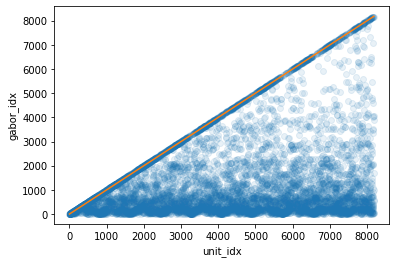

In [45]:
plt.scatter(np.arange(len(responses)), np.array(responses).argmax(0), alpha=0.1)
plt.plot(np.arange(len(responses)), np.arange(len(responses)), c='tab:orange')
plt.xlabel('unit_idx')
plt.ylabel('gabor_idx')
plt.show()

In [46]:
for unit, response in tqdm(enumerate(np.array(responses).T)):
    if not np.any(np.where(response == response.max())[0] == unit):
        print('failed')
        break

8182it [00:01, 4847.87it/s]


In [48]:
batch_size = 100
batch_idx = 1

batch = next(gabor_set.image_batches(batch_size))

images_batch = batch.reshape((batch_size,) + tuple(gabor_set.canvas_size))
images_batch = np.expand_dims(images_batch, axis=1)
images_batch = torch.tensor(images_batch).cuda().float()

activations_batch = model(images_batch, data_key=data_key).detach().cpu().numpy().squeeze()

In [61]:
activations_batch.shape

(100, 8182)

In [117]:
max_idx = np.zeros(8182)
max_activations = np.zeros(8182)

new_max_idx = activations_batch.argmax(0)
new_max_activations = activations_batch.T[range(len(new_max)), new_max]

max_idx[new_max_activations > max_activations] = new_max_idx[new_max_activations > max_activations] + batch_size * batch_idx
max_activations[new_max_activations > max_activations] = new_max_activations[new_max_activations > max_activations]

In [60]:
current_max_idx = np.random.randint(0, 10, size=8000)

for batch_idx in range(10):
    max_act = np.random.randint(0, 10, size=8000)

    print(current_max_idx)
    print(max_act)
    current_max_idx[max_act > 0] = max_act[max_act > 0] - 1 + batch_size * batch_idx
    print(current_max_idx)
    print()

[5 4 4 ... 1 7 8]
[9 3 4 ... 5 2 7]
[8 2 3 ... 4 1 6]

[8 2 3 ... 4 1 6]
[2 0 8 ... 6 5 0]
[101   2 107 ... 105 104   6]

[101   2 107 ... 105 104   6]
[0 2 8 ... 9 2 8]
[101 201 207 ... 208 201 207]

[101 201 207 ... 208 201 207]
[8 9 8 ... 8 8 4]
[307 308 307 ... 307 307 303]

[307 308 307 ... 307 307 303]
[8 2 9 ... 1 3 2]
[407 401 408 ... 400 402 401]

[407 401 408 ... 400 402 401]
[5 7 5 ... 0 7 9]
[504 506 504 ... 400 506 508]

[504 506 504 ... 400 506 508]
[2 5 5 ... 8 5 5]
[601 604 604 ... 607 604 604]

[601 604 604 ... 607 604 604]
[9 0 2 ... 5 0 1]
[708 604 701 ... 704 604 700]

[708 604 701 ... 704 604 700]
[7 6 7 ... 1 6 6]
[806 805 806 ... 800 805 805]

[806 805 806 ... 800 805 805]
[4 9 9 ... 0 4 7]
[903 908 908 ... 800 903 906]

